In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [17]:
Dataset = JHUDataset()

def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 3.2
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        #'projection_iterations': 25, # Number of iterations into the future to project
        'projection_iterations': 60, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        #'incubation_period': 5, # In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'use_harvard_init': use_harvard_init, #If True use the harvard model inputs for inital conditions and N (recreate their graph)

        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'total_infected_period': 12, # In days
        'duration_mild_infections': 6, # In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'case_fatality_rate': .0109341104294479,
        'beta': 0.5,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,
        'presymptomatic_period': 1,
        'exposed_from_infected': True,

        #'model': 'sir',
        'model': 'seir',
    }
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1/MODEL_PARAMETERS['beta']

    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.35,
        datetime.date(2020, 5, 18): r0
    },
    {
        datetime.date(2020, 4, 3): 1.3,
        datetime.date(2020, 5, 18): 3.087079333

    },
    {
        datetime.date(2020, 3, 3): 5,
    },
]

In [5]:
#JHUDataset.get_timeseries_by_country_state('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#Dataset.get_beds_by_country_state('USA', 'NY')

In [6]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [7]:
1 / .7 

1.4285714285714286

In [8]:
100 * (1/0.7)

142.85714285714286

In [9]:
# Params with True
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000

# params with False
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 28995881.0

In [10]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

{"beta": [0, 1.7243828528610667e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 1.0, "gamma": [0, 0.15455, 0.07820909090909091, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.0127], "mu": 0.1537993849696997}
3.087079333
        date     total  susceptible  exposed  infected  infected_a  \
0 2020-03-03  28995881            0     0.00      1.00        0.00   
1 2020-03-04  28995881            0     0.00      1.00        0.00   
2 2020-03-05  28995881            0     0.00      4.00        0.00   
3 2020-03-06  28995881            0     0.00      5.00        0.00   
4 2020-03-07  28995881            0     0.00      9.00        0.00   

   infected_b  infected_c  recovered  dead  
0        0.00        0.00       0.00  0.00  
1        0.00        0.00       0.00  0.00  
2        0.00        0.00       0.00  0.00  
3        0.00        0.00       0.00  0.00  
4        0.00        0.00       0.00  0.00  
date           2020-11-20 00:00:00
total                     2

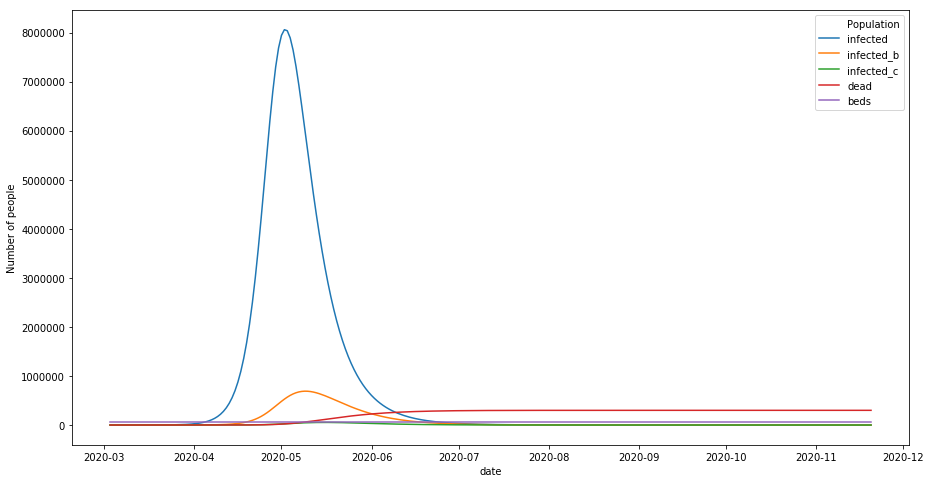

In [27]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

{"beta": [0, 1.7243828528610667e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 1.0, "gamma": [0, 0.15455, 0.07820909090909091, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.0127], "mu": 0.1537993849696997}
3.087079333
        date  dead  exposed  infected  infected_a  infected_b  infected_c  \
0 2020-03-03  0.00     0.00      1.00        0.00        0.00        0.00   
1 2020-03-04  0.00     0.00      1.00        0.00        0.00        0.00   
2 2020-03-05  0.00     0.00      4.00        0.00        0.00        0.00   
3 2020-03-06  0.00     0.00      5.00        0.00        0.00        0.00   
4 2020-03-07  0.00     0.00      9.00        0.00        0.00        0.00   

   recovered  susceptible     total  
0       0.00         0.00  28995881  
1       0.00         0.00  28995881  
2       0.00         0.00  28995881  
3       0.00         0.00  28995881  
4       0.00         0.00  28995881  
date           2020-11-20 00:00:00
dead                     29

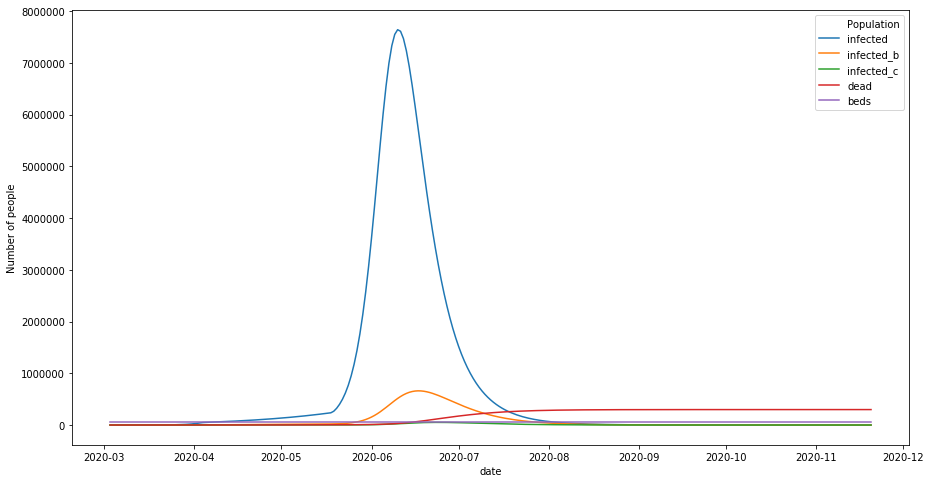

In [29]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[4])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

In [13]:
#initervention_df.describe()

In [30]:
print(initervention_df.head(25))

         date  dead  exposed  infected  infected_a  infected_b  infected_c  \
0  2020-03-03  0.00     0.00      0.00        0.00        0.00        0.00   
1  2020-03-04  0.00     0.00      0.00        0.00        0.00        0.00   
2  2020-03-05  0.00     0.00      0.00        0.00        0.00        0.00   
3  2020-03-06  0.00     0.00      0.00        0.00        0.00        0.00   
4  2020-03-07  0.00     0.00      0.00        0.00        0.00        0.00   
5  2020-03-08  0.00     0.00      0.00        0.00        0.00        0.00   
6  2020-03-09  0.00     0.00      0.00        0.00        0.00        0.00   
7  2020-03-10  0.00     0.00      0.00        0.00        0.00        0.00   
8  2020-03-11  0.00     0.00      0.00        0.00        0.00        0.00   
9  2020-03-12  0.00     0.00      0.00        0.00        0.00        0.00   
10 2020-03-13  0.00     0.00      0.00        0.00        0.00        0.00   
11 2020-03-14  0.00     0.00      0.00        0.00        0.00  

{"beta": [0.0, 6.971713059633818e-09, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 1.0, "gamma": [0, 0.15455, 0.07820909090909091, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.0127], "mu": 0.1537993849696997}
1.2999851064597285
date           2020-11-20 00:00:00
dead                     296058.76
exposed                       0.01
infected                      1.51
infected_a                    0.19
infected_b                    1.07
infected_c                    0.25
recovered              26796434.48
susceptible             1903386.23
total                     28995881
beds                         66691
Name: 264, dtype: object


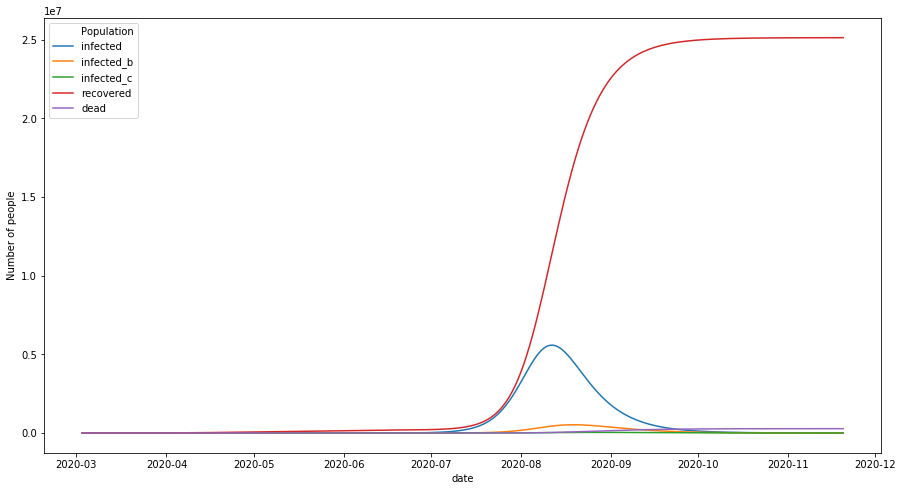

In [15]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[1])
    
print(initervention_df.iloc[-1])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
#chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
plot_df(df, chart_cols)

[1.20518064e+07 7.23077629e+07 9.63232006e+06 8.55691933e+05
 2.31194804e+09 2.32811500e+07]
(365, 6)


(1, 28995881.0)

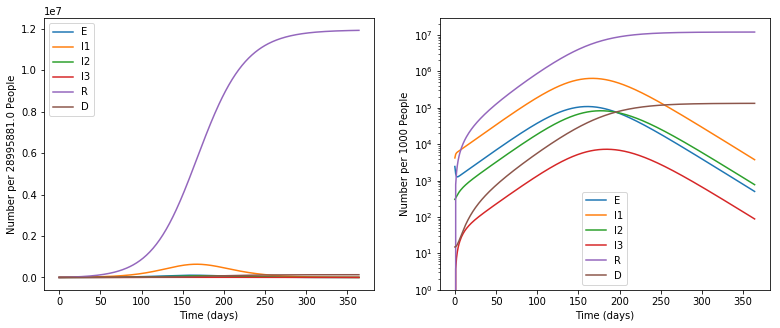

In [16]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N =  28995881.00
    #N = 10000
    tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel(f"Number per {str(N)} People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

plt.ylim([1,N])
#plt.tight_layout()